In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.inference import DBNInference

from model_v0 import DumbDiscretizer, pgmpy_friendly_transformer

### Parameters of the experience 

In [68]:
nb_points = 1000  # nb of points in the dataset
sliding_window = 2  # sliding winodw for pgmpy dataset

Generate data 

In [69]:
# function to generate data 

def generate_data(nb):
    """
    Given an integer generate data as describe above.

    :params nb: int 
        Number of datapoints to generate

    :return dictionary 
        Keys are "States" and "Observations". 
    """
    
    # initialize state vector 
    X1 = np.zeros(nb, dtype=np.float64)
    X2 = np.zeros(nb, dtype=np.float64)
    Y = np.zeros(nb, dtype=np.float64)

    # generate random variables 
    epsilon_1 = np.random.normal(0, scale=5, size=nb-1)
    epsilon_2 = np.random.normal(10, scale=1, size=nb-1)
    epsilon_3 = np.random.normal(0, scale=1, size=nb-1)

    for i in range(0, nb):
        """if i == 0: 
            X1[i] = np.random.uniform(-150, 150)
            X2[i] = np.random.uniform(-150, 150)
            Y[i] = np.random.uniform(-150, 150)
            continue"""

        X1[i] = X1[i-1] + epsilon_1[i-1]
        # X2[i] = .5 * (X1[i] + X1[i-1]) - X2[i-1] + epsilon_2[i-1]
        X2[i] = .33 * (X1[i] + X1[i-1] + X2[i-1]) + epsilon_2[i-1]
        Y[i] = np.abs(X2[i]) + epsilon_3[i-1]

    return X1, X2, Y

In [70]:
# generate random data
X1, X2, Y = generate_data(nb_points)

# convert to dataframe
my_data = pd.DataFrame()
my_data["X1"] = X1
my_data["X2"] = X2
my_data["Y"] = Y

# observe subsample
my_data.head()

,X1,X2,Y
0,-7.345312,7.055158,7.888224
1,-10.203158,6.546636,5.863953
2,-9.888681,6.562284,7.457046
3,-15.632666,3.149783,1.544062
4,-16.222966,-1.171701,1.296139


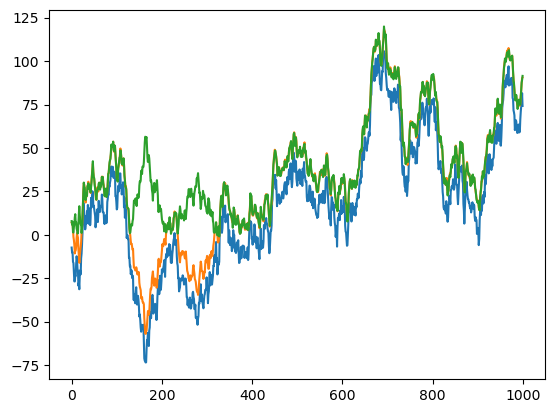

In [82]:
plt.plot(np.arange(nb_points), X1, label="X1")
plt.plot(np.arange(nb_points), X2, label="X2")
plt.plot(np.arange(nb_points), Y, label="Y")

### Discretization 

In [72]:
nb_classes = {
    "X1": 30, 
    "X2": 30, 
    "Y": 30
}

discretizer = DumbDiscretizer(my_data, nb_classes=nb_classes)
my_data_index = discretizer.df

In [73]:
my_data_index.head()

,X1,X2,Y
0,11,11,2
1,11,11,2
2,11,11,2
3,10,10,1
4,10,9,1


### PGMPY friendly dataframe

In [74]:
my_data_index_pgmpy = pgmpy_friendly_transformer(my_data_index, sliding_window=sliding_window)

In [75]:
my_data_index_pgmpy.head(25)

,"(X1, 0)","(X2, 0)","(Y, 0)","(X1, 1)","(X2, 1)","(Y, 1)"
0,11,11,2,11,11,2
1,11,11,2,11,11,2
2,11,11,2,10,10,1
3,10,10,1,10,9,1
4,10,9,1,9,9,2
5,9,9,2,8,9,2
6,8,9,2,8,8,3
7,8,8,3,9,8,3
8,9,8,3,9,8,2
9,9,8,2,10,8,2


### Model creation  

In [76]:
# build model 
dbn = DBN(
    [
        (("X1", 0), ("X2", 0)),
        (("X2", 0), ("Y", 0)),
        (('X1', 0), ("X2", 1)),
        (('X2', 0), ("X2", 1)),
        (("X1", 1), ("X2", 1)),
        (("X2", 1), ("Y", 1))
    ]
)

In [77]:
dbn.fit(my_data_index_pgmpy.iloc[:-5, :])

### Model validation

In [78]:
my_data.tail()

,X1,X2,Y
995,70.751977,79.988562,79.059105
996,73.814794,82.954319,83.314266
997,75.615970,87.176679,87.654208
998,81.528109,90.229702,89.152059
999,74.182798,90.639512,91.472578


83.55289316057703
51.53817157356367


Text(0, 0.5, 'Proba')

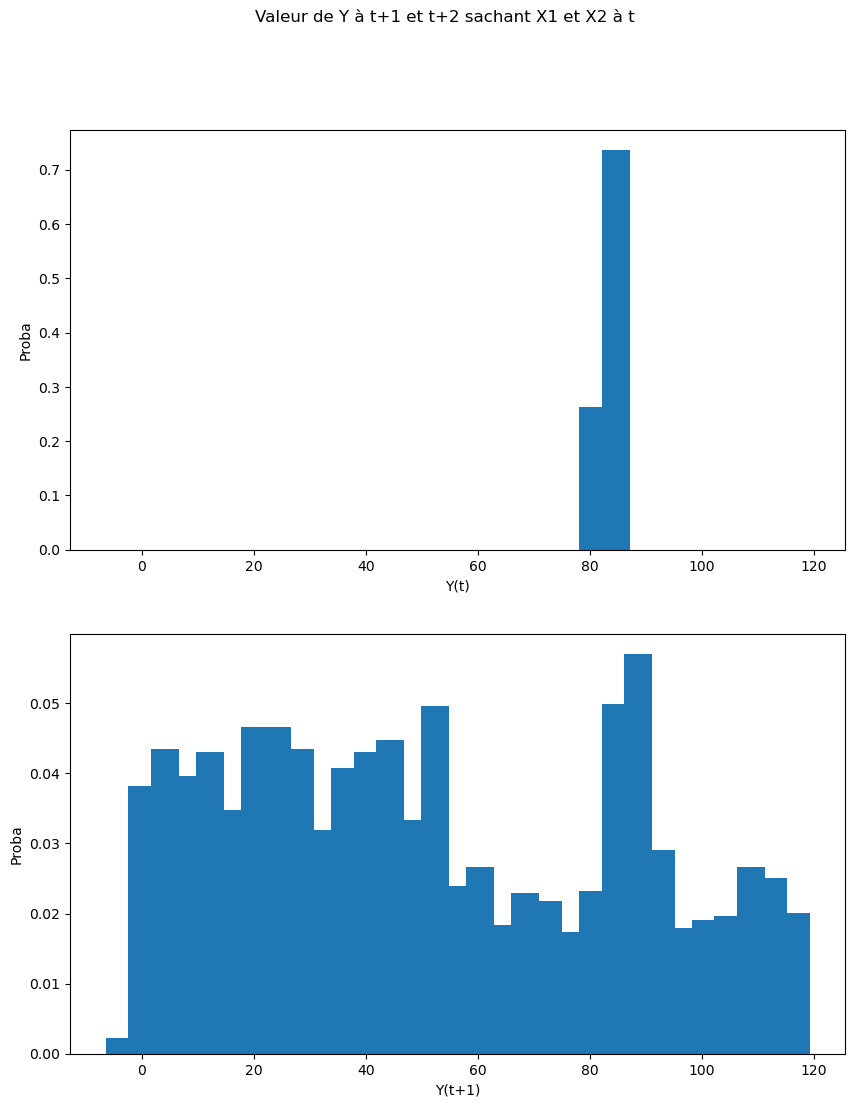

In [80]:
# framework pour l'inférence des DBN 
inference = DBNInference(dbn)

# known observation
evidence = {
    ('X1', 0): discretizer.indexer("X1", 75.62), 
    ('X2', 0): discretizer.indexer("X2", 87.18), 
}  # value must be indice 

# result of question given evidence what about variable
result = inference.forward_inference(variables=[('Y', 0), ("Y", 1)], 
                                     evidence=evidence)
proba_0 = result[("Y", 0)].values
proba_1 = result[("Y", 1)].values

# x-axis
x_ = [discretizer.reverse_indexer(column_name="Y", ind=i) for i in range(len(proba_0))]

print(np.dot(proba_0, x_))
print(np.dot(proba_1, x_))

fig, ax = plt.subplots(2, 1, figsize=(10, 12))

fig.suptitle("Valeur de Y à t+1 et t+2 sachant X1 et X2 à t")

ax[0].bar(x_, proba_0, width=5.)
ax[0].set_xlabel("Y(t)")
ax[0].set_ylabel("Proba")

ax[1].bar(x_, proba_1, width=5.)
ax[1].set_xlabel("Y(t+1)")
ax[1].set_ylabel("Proba")